# HTTP

## HTTP 1.0 - 1996年
http的基本特点是“一来一回”，客户端发起一个tcp连接，在这个连接上面发送HTTP Request到服务器，服务器通过这个连接返回一个HTTP Response，然后关闭连接。每来一个请求，就要开一个连接，请求完成，关闭连接。

缺点：
- 性能问题：连接的建立和关闭都是非常耗时的操作。对于一个网页，往往需要发送很多个请求到后端，这样就要建立多个连接才能打开一个页面。虽然可以并行的打开多个连接，同时发送请求，但是连接数毕竟是有限的。
- 服务器推送问题：这样“一来一回”的形式不支持推送，服务器无法主动向客户端推送消息。但很多的应用确实有这种需求的。

针对以上两个问题，HTTP1.0的解决方法：
- Keep-Alive机制，在HTTP Request的头部增加Connection：Keep-Alive，服务器在收到这样的请求时，会在返回的Response中也加好这样的字段，然后等待客户端在当前这个连接上的下一个请求。
    - 缺点：这样产生的问题是 ，服务器的连接不被关闭，导致服务器的连接数很快就会耗光。因此，服务器在回给前端的Response的Header中，回增加Keep-Alive timeout参数，过一段时间后，该连接上没有新的请求进来，这个连接就会被关闭掉。
        - 缺点：这样做也会产生一个问题，就是前端没办法知道连接什么时候连接关闭了，或者说前端怎么知道接收回来的数据是完整的呢？所以，在Http Response的头部，返回了一个Content-Length：xxx的字段，告诉前端HTTP Body共有多少个字节，客户端接收到这些字节后，就知道相应成功并且接收完毕。

## HTTP 1.1 - 1999年

### Content-Length机制的问题
从1.0时代的方案就可以看出来，连接的复用非常的重要，所以到了1.1以后就把连接复用变成了一个默认的属性。除非在Request头部增加Connection：Close属性，服务器才回在请求完毕后主动关闭连接。

缺点：
- 这种通过Content-Length机制实现的连接复用在后端返回的数据是动态生成的时候，就比较麻烦了。即使能计算，也需要在内存中进行渲染，才能计算出长度，这样非常的耗费时间和性能。
    
针对上面这个问题的HTTP 1.1给出的解决方案：
- chuck机制：通过在Header中增加Transfer-Encoding：chunked字段，这个标志会对每个chuck标记当前chuck大小，并在最后返回0时表示发送完毕。

### Head-of-Line Blocking问题
有了连接复用之后，减少了建立连接、关闭连接的开销。但还是存在一个问题，在一个连接上，连接是串行的，如下图左，这样就导致了效率的低下。

为此，HTTP 1.1引入了Pipeline机制，允许在同一个连接上，一个Request发出去后，Response还没有回来之前，发送下一个Request，再下一个Request，这样就提高了在同一个连接上的处理效率。如下图右。
![head-of-line-pipeline.png](assets/head-of-line-pipeline.png)

但是Pipeline的模型，存在一个致命的问题，就是Head-of-Line Blocking（队头阻塞）。如上图右所示，Pipeline发送的Request顺序是1、2、3，那么接受的顺序也必须是1、2、3，这样才能将Request和Response一一配对。但是，一旦1请求发生延时，则2、3都会被阻塞，这就是Head-of-Line Blocking，如下图。正因为如此，很多浏览器把Pipeline关闭了。

![head-of-line-blocking.png](assets/head-of-line-blocking.png)

一方面，Pipeline机制不能用；另一方面，流量器对于每个域名存在只能开6~8个连接，那么该如何提高性能呢？

以下是一些解决的方法：
- Spriting技术：这种技术主要针对于小图片，当一个页面中存在很多小图片时，可以在服务器中，讲这些小图片拼成一张大图，到了浏览器中再通过JS或者CSS，从大图中截取一小块进行显示。
- Inlining技术：这也是一种针对小图片的技术，将图片的原始数据嵌入到CSS文件中。
    ```css
    .icon1 {
            background: url(data:image/png;base64, <data>) no-repeat;
        }
    ```
- JS拼接：把大量小的JS文件合并成一个并压缩
- 请求分片技术：之前说过浏览器对于每个域名存在只能开6~8个连接的限制。我们可以多做几个域名，来绕开浏览器的限制。同时，现代网站的静态资源大部分都是走的CDN，通过这种方法并不会给服务端造成过大的压力。

### “一来多回”问题
在HTTP 1.0和1.1中，都无法直接做到服务器的主动推送，但实际上这样的需求又存在，下面介绍几种解决该问题的方法：
- 客户端定期轮训：比如说每5s向服务端发送请求查询，这种方法基本已经不用了
- WebSocket：这是一种很美的方案，但是除了在一些非常频繁的交互应用中，并不是一个很好的方案，一方面，目前WebSocket的浏览器兼容性并不好，还有很多的场景存在不能稳定的现象，需要大量的代码处理才能带来稳定的体验；另一方面，长连接对于客户端和服务端都会带来比较大的压力。所以，不是非常频繁的数据交互，并不推荐使用websocket。
- HTTP长轮训：前端发起HTTP请求，如果服务端有新消息，就立即返回；如果没有，则服务器夯住此连接，配合epool，可以有很高的性能，这也是目前比较主流的方案。
- HTTP Streaming：借用之前说过的chuck机制，发送一个“没完没了”的chuck流，这种方案主要是没有HTTP长轮训方案实现简单。

### 断点续传
与HTTP 1.0相比较，1.1也实现了断点续传功能，当前端下载文件时，中途断掉，可以继续接着上次的地方下载。只要在请求头中加上Range: fisrt offset - last offset即可
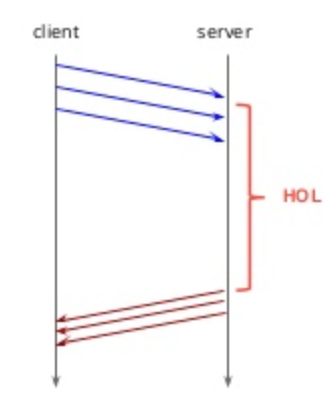
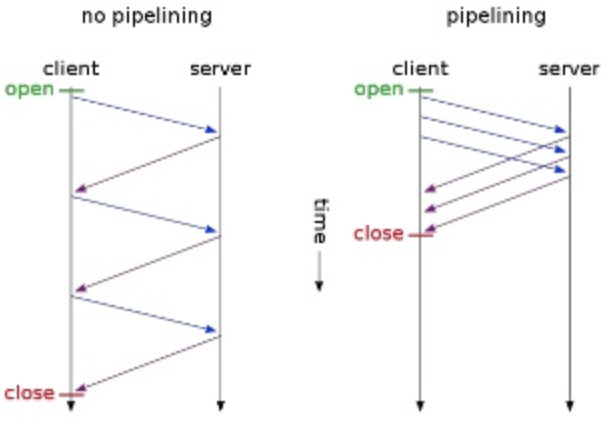

## HTTP/2 - 2015年
在说HTTP2之前，就不得不提Google的SPDY了，这是Google提出的一个实验性的协议，2009年发布，2012年得到Chrome、Firefox和Opera的支持，很多大型网站，比如Google、Twitter、Facebook和小型网站也在其基础设施内部署SPDY，观察到这一趋势后，HTTP工作组决定吸纳SPDY的经验和教训，并在此基础上制定了HTTP/2协议。没有叫做HTTP 2.0，就是因为工作组认为该协议已经很完善，后面不会再有小版本，如果有的话那应该是HTTP/3之类的。

### HTTT/2架构
为了能够兼容HTTP1.1，HTTP工作组将HTTP/2放置在HTTP1.1和TCP之间，相当于一个转换层的作用。

!<img src="assets/http:2.jpg" width="300px">

### 二进制分帧
这也是HTTP/2中的重头戏，就是为了解决在HTTP 1.1中Pipeline并没有解决掉的Head-of-Line Blocking问题。

这里面HTTP/2主要的工作如下：
- HTTP 1.1层按上图依然发挥着之前的作用，接收到明文的字符串
- HTTP/2层将这些明文转换成二进制，并且分成多个帧（数据块）来发送
- 讲这些数据块扔给TCP进行发送
- 在接收Response时，则由下至上的进行操作

对于每一个域名，只维护一个TCP连接。因为TCP是全双工的，即来回有两个通道。

![http2-flow1.png](assets/http2-flow1.png)

这里有个问题就是，如何把这些打乱发送出去的帧，重新组装起来，并且还要把他们一一配对。其实也很简单，就是将请求和响应组成一个逻辑上的流，如上图，并且给每个帧都打上流的标签。这样在TCP层面上虽然还是串行的，但是在HTTP层面看，就是并行的了。

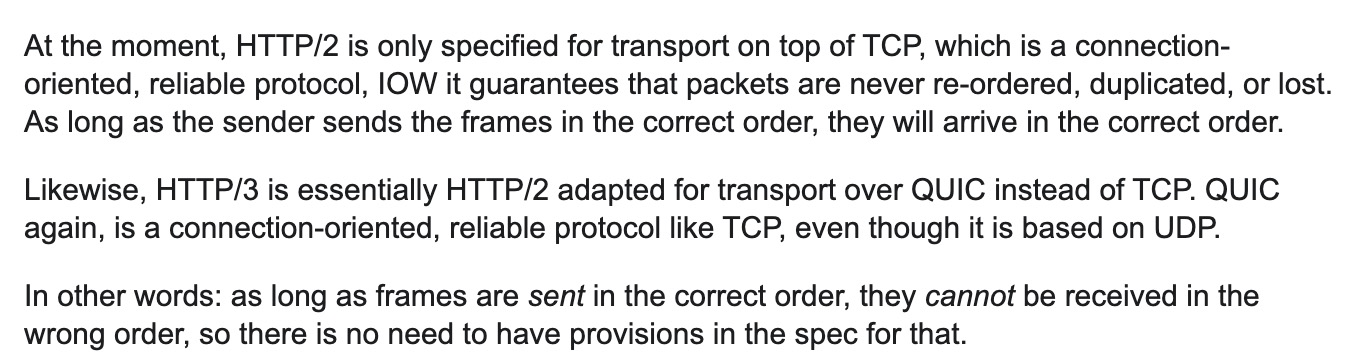

其实这样也没有完全的避免队头阻塞，只是将其细化到了帧的粒度上。只要使用TCP就绕不开队头阻塞的问题，因为TCP是个串行的协议！

虽然没有完全的解决这个问题，但是却降低了发生的可能性。我们具体分析下为什么会这样？

<img src="assets/http2-flow2.png" width="400px">

如上图，如果Request 1的响应迟迟不回来，原因可能有两种：
- 服务器对Request 1处理的慢
- 服务器对Request 1处理的很及时，但是网络传输慢

对于原因2，如果刚好请求1的第一帧又在队头，则即使二进制分帧也解决不了队头阻塞的问题。但是对于问题1，Request 2、3的Response分帧后，是优先于Request 1的响应发出去的，那么Request 2、3的Response就不会被Request 1阻塞，从而避免了队头阻塞的问题。所以在HTTP/2中，可以指定每个流的优先级，当资源有限的时候，服务器根据流的优先级来决定，先发哪些流来避免请求阻塞。

<img src="assets/http1.1-flow.png">

<img src="assets/http2-flow.png">

### 头部压缩
使用HPACK协议进行头部压缩，减小头部的大小。

### 服务器推
[参考资料](https://zhuanlan.zhihu.com/p/32061067)

## HTTPS 
### SSL/TLS
SSL协议由网景公司发明与1994年，后由IETF进行标准化，发布为TLS，在应用层普遍习惯称两者为SSL/TLS。它在网络协议中的位置如下：

![tls.png](assets/tls.png)

#### 对称加密
这是一种很nature的想法，但是这种方式，秘钥的明文传输是及其不安全的，所以我们要想其他的办法。

![entropy-pair.png](assets/entropy-pair.png)


#### 双向非对称加密
每个节点都维护自己的pubKey和priKey。

![entropy-pair1.png](assets/entropy-pair1.png)

pubKey的特点是：
- 是由priKey计算出来的，反向是不能推算的
- pubKey加密的数据，可以由priKey解密

上述的流程如下：
- 签名和验签：私钥签名、公钥验签，目的是防止篡改。如果第三方截取到消息进行篡改则接收方验签就会过不了。同时，也防抵赖，既然没人能够篡改，只可能是发送方自己发出的。
- 加密和解密：公钥加密、私钥解密，目的是防止第三方拦截和偷听。

这里也存在一个和对称加密一样的问题，公钥怎么传输。

#### 单向非对称加密
![entropy-tls.png](assets/entropy-tls.png)


#### 中间人攻击
上面的这几种模式中，都存在着公钥是以明文发送的问题，也就是谁都可以拿到这个公钥。典型的中间人攻击如下：

![mitm.png](assets/mitm.png)

解决方法：
引入一个中间机构CA，当服务器把公钥发送给客户端时，不是直接发送公钥，而是发送公钥对应的证书，客户端再拿着证书去CA进行验证是否是合法的服务器。

![ca.png](assets/ca.png)

#### CA伪造
这像是个鸡生蛋蛋生鸡的问题，CA如果被伪造了怎么办？引入了信任链和根证书。下面这个认证的体系被标准化后，叫做PKI体系。

![trust-chain.png](assets/trust-chain.png)

### TLS全过程- 四次握手

![tls-whole.png](assets/tls-whole.png)


### HTTPS全过程
![https.png](assets/https.png)
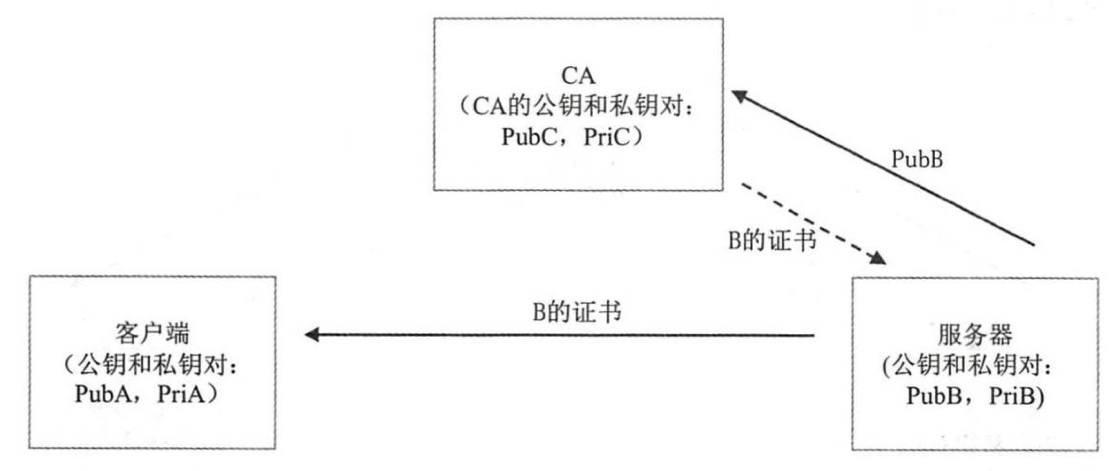
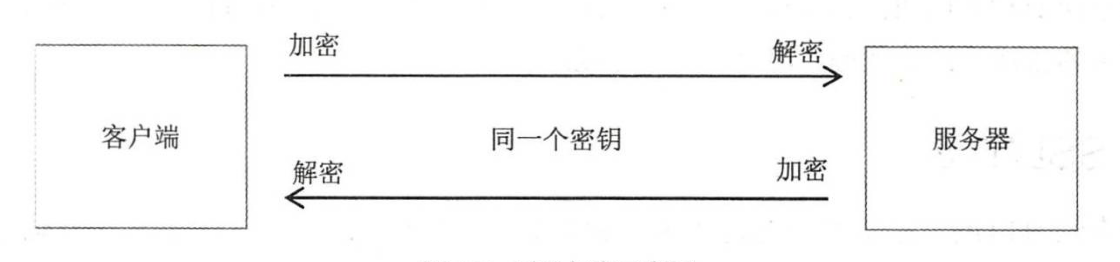
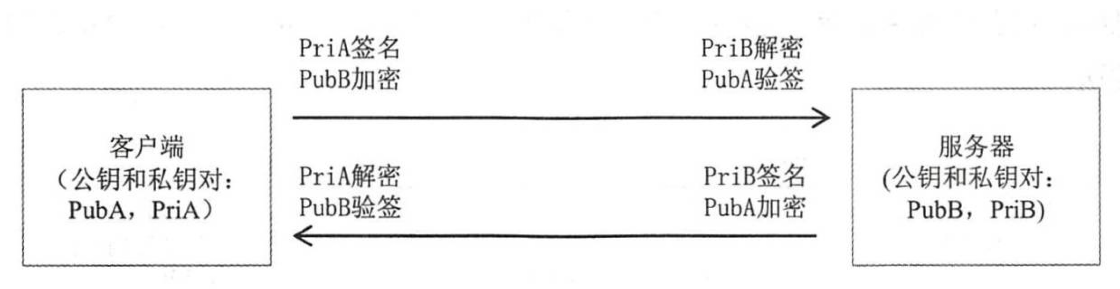
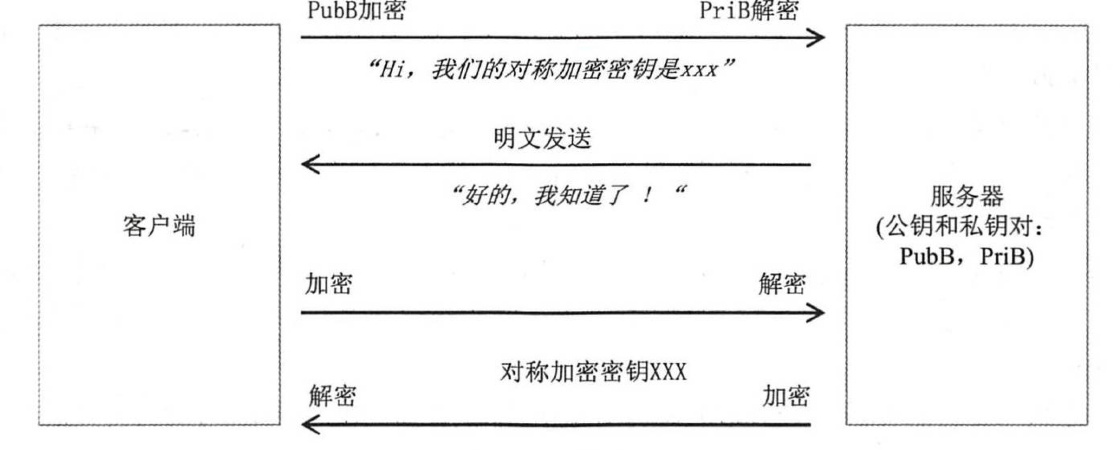
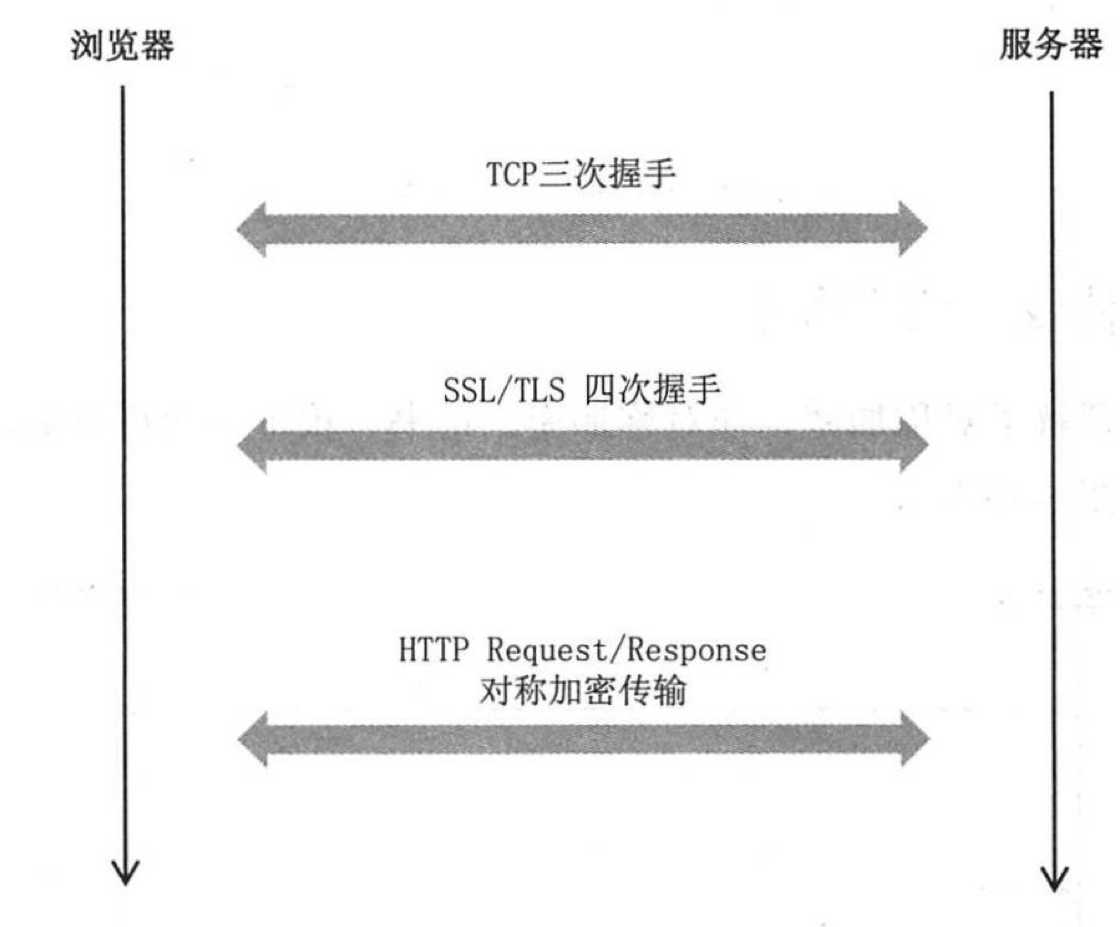
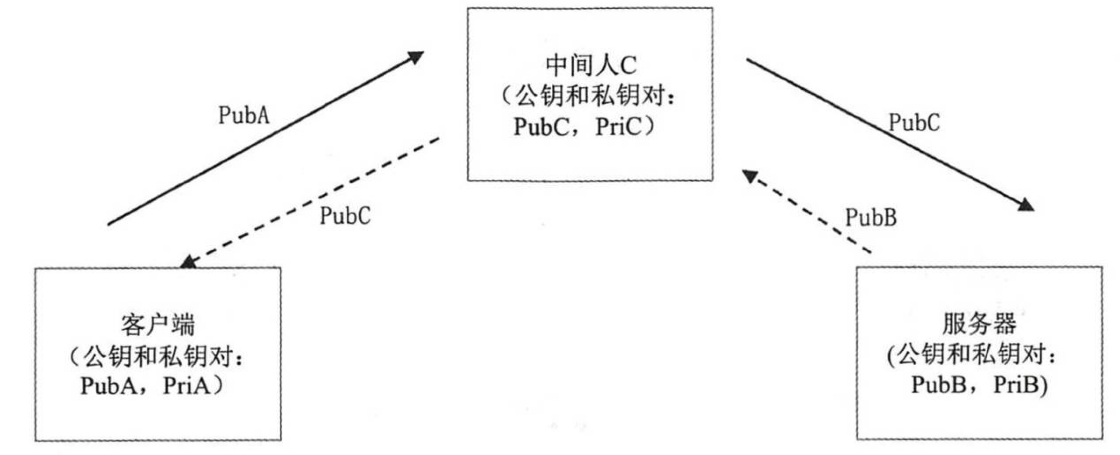
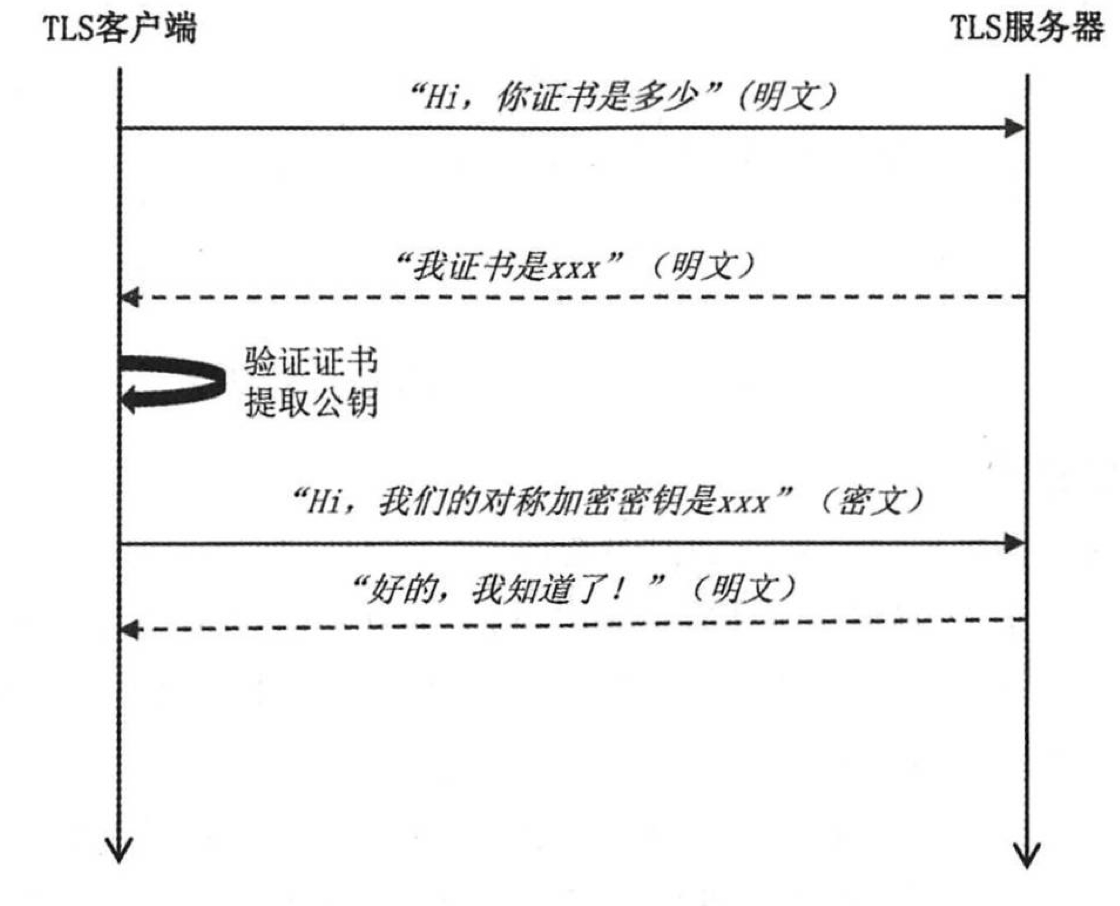
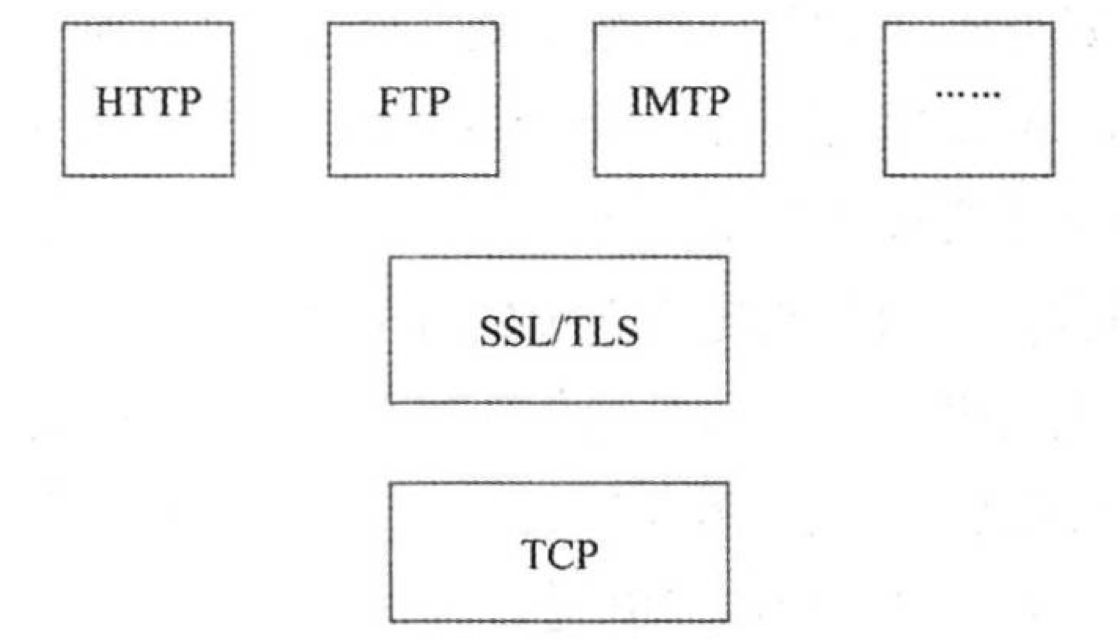
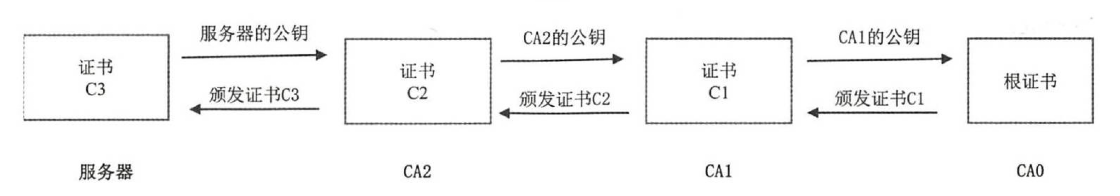

## TPC/UDP

### 可靠与不可靠
标准：
- 是否会丢包、重包？每个数据包在传输的过程中都会经过很多的节点，节点发生故障是非常正常的事情
- 时序是否会混乱？在传输的过程中，每个数据包走的路径可能是不相同的，自然传输的快慢就不相同

所以，可以说在网络上传输数据，“不可靠”其实是常态。

TCP解决上述问题的思路：
- 不丢包 - ACK+重发：发送端每发送一个包，对方就会给发送端一个确实的消息(ACK)，如果在指定时间内没有收到ACK，就重发这个包。但是，如果串行的去发送的话效率太低了。所以，TCP就在发送包的时候给每个包一个单调递增的编号，接收端只要回复ACK=3就表示前三个包已经收到了
- 不重包：上述描述中说到，只要在规定时间内没有接收到ACK就重新发送，但是这也有可能是ACK的包还在网络上走，还没有到发送端而已。如果这种情况下，发送端重新发送包的话，接收端就会收到重复的包。比对每个包显然是非常的耗时的，所以就用到了刚才说到的ACK=3这个消息，但凡接收到的包大于ACK后数字的一律丢弃。
- 时序问题：保持时序其实也是使用ACK=k的这种机制，接收端总是在顺序的接收包，如果中间出现没有收到的包，则一直不给对方发送ACK的消息，这时候对方就会重复发送，直到接收端顺序收到数据为止。

TCP就是通过上述这样机制来确保可靠性的。但是，同时也可以看出，效率其实并不是很高的，这也是之前说过的为什么只要使用TCP就没有办法避免Head-of-Line Blocking的问题。其实，在很多现代的分布式系统中，也是使用上述这些朴素的技术来确保消息的不重、不漏的。

### TCP的“假连接”和状态机
![tcp-states.png](assets/tcp-states.png)

#### 发起邀请的三次握手（网络2将军问题）
![tcp-3rd.png](assets/tcp-3rd.png)

#### 结束的四次握手
![tcp-4rd.png](assets/tcp-4rd.png)

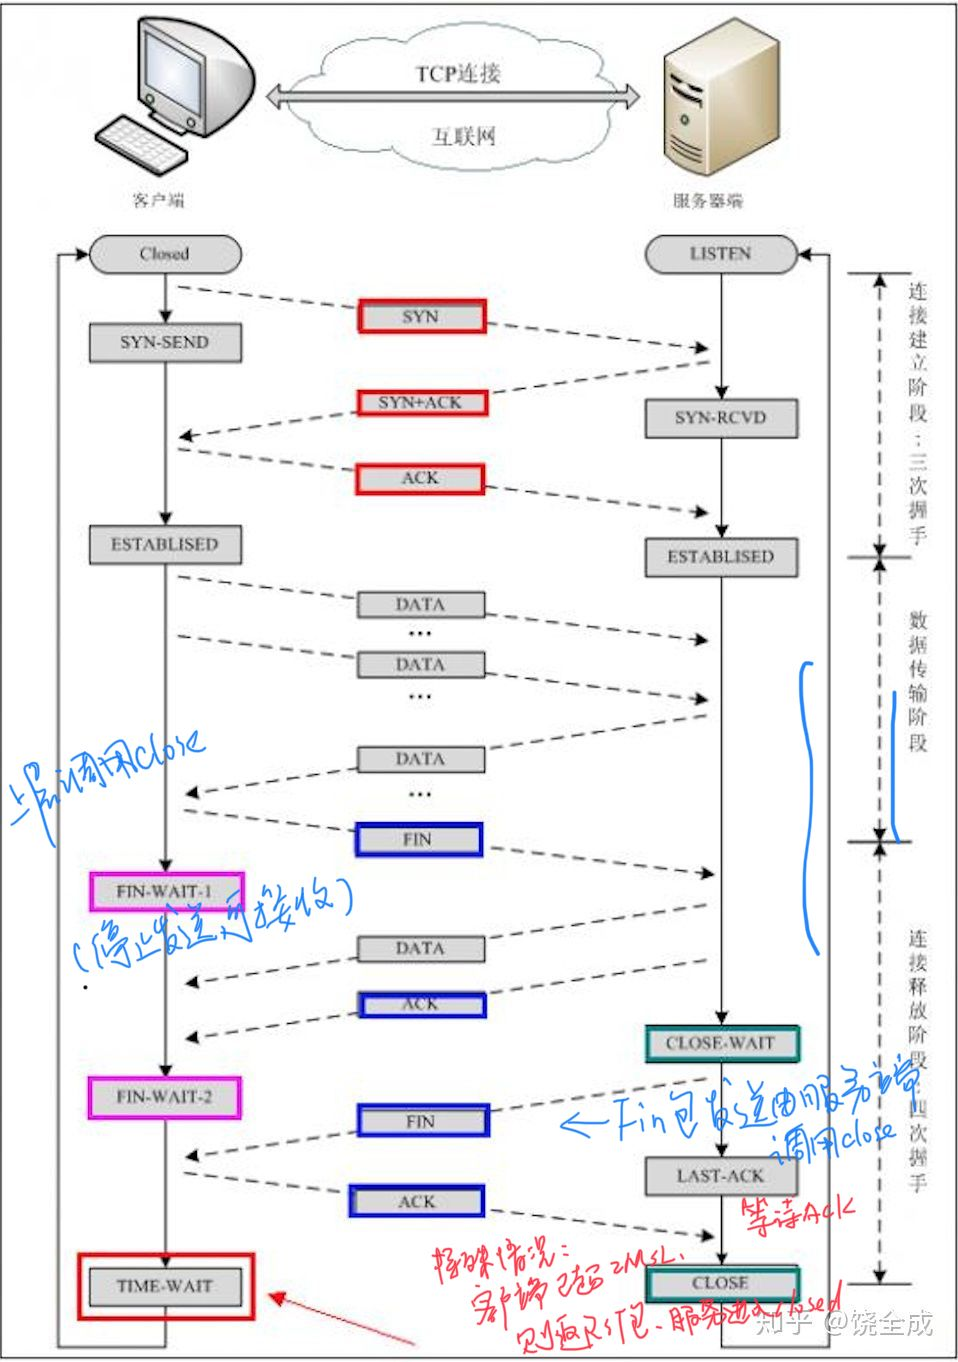

> B发送FIN，进入LAST_ACK状态，A收到这个FIN包后发送ACK包，B收到这个ACK包，然后进入CLOSED状态B发送FIN，进入LAST_ACK状态，A收到这个FIN包后发送ACK包，由于某种原因，这个ACK包丢失了，B没有收到ACK包，然后B等待ACK包超时，又向A发送了一个FIN包      a) 假如这个时候，A还是处于TIME_WAIT状态(也就是TIME_WAIT持续的时间在2MSL内)A收到这个FIN包后向B发送了一个ACK包，B收到这个ACK包进入CLOSED状态      b) 假如这个时候，A已经从TIME_WAIT状态变成了CLOSED状态          A收到这个FIN包后，认为这是一个错误的连接，向B发送一个RST包，当B收到这个RST包，进入CLOSED状态    c) 假如这个时候，A挂了（假如这台机器炸掉了）【第四种情况，不在参考链接里】        B没有收到A的回应，那么会继续发送FIN包，也就是触发了TCP的重传机制，如果A还是没有回应，B还会继续发送FIN包，直到重传超时(至于这个时间是多长需要仔细研究)，B重置这个连接，进入CLOSED状态.

>通常，CLOSE_WAIT 状态在服务器停留时间很短，如果你发现大量的 CLOSE_WAIT 状态，那么就意味着被动关闭的一方没有及时发出 FIN 包，一般有如下几种可能：
程序问题：如果代码层面忘记了 close 相应的 socket 连接，那么自然不会发出 FIN 包，从而导致 CLOSE_WAIT 累积；或者代码不严谨，出现死循环之类的问题，导致即便后面写了 close 也永远执行不到。
响应太慢或者超时设置过小：如果连接双方不和谐，一方不耐烦直接 timeout，另一方却还在忙于耗时逻辑，就会导致 close 被延后。响应太慢是首要问题，不过换个角度看，也可能是 timeout 设置过小。
BACKLOG 太大：此处的 backlog 不是 syn backlog，而是 accept 的 backlog，如果 backlog 太大的话，设想突然遭遇大访问量的话，即便响应速度不慢，也可能出现来不及消费的情况，导致多余的请求还在队列里就被对方关闭了。

这就是后端同学经常见到的大量TIME_WAIT状态的问题：
- 不要让服务器主动关闭连接，这样服务器的连接就不会处于TIME_WAIT
- 客户端做连接池，复用连接，不要重复的创建和关闭，这也是HTTP1.0和2的实现思路
- 修改系统tcp参数


```shell
    netstat -ant|awk '/^tcp/ {++S[$NF]} END {for(a in S) print (a,S[a])}'
```


```shell
    net.ipv4.tcp_syncookies = 1 #表示开启SYN Cookies。当出现SYN等待队列溢出时，启用cookies来处理，可防范少量SYN攻击，默认为0，表示关闭；
    net.ipv4.tcp_tw_reuse = 1 #表示开启重用。允许将TIME-WAIT sockets重新用于新的TCP连接，默认为0，表示关闭；
    net.ipv4.tcp_tw_recycle = 1 #表示开启TCP连接中TIME-WAIT sockets的快速回收，默认为0，表示关闭。
    net.ipv4.tcp_fin_timeout #修改系默认的 TIMEOUT 时间 
    net.ipv4.tcp_keepalive_time = 1200 
    #表示当keepalive起用的时候，TCP发送keepalive消息的频度。缺省是2小时，改为20分钟。
    net.ipv4.ip_local_port_range = 1024 65000 
    #表示用于向外连接的端口范围。缺省情况下很小：32768到61000，改为1024到65000。
    net.ipv4.tcp_max_syn_backlog = 8192 
    #表示SYN队列的长度，默认为1024，加大队列长度为8192，可以容纳更多等待连接的网络连接数。
    net.ipv4.tcp_max_tw_buckets = 5000 
    #表示系统同时保持TIME_WAIT套接字的最大数量，如果超过这个数字，TIME_WAIT套接字将立刻被清除并打印警告信息。
    默认为180000，改为5000。对于Apache、Nginx等服务器，上几行的参数可以很好地减少TIME_WAIT套接字数量，但是对于 Squid，效果却不大。此项参数可以控制TIME_WAIT套接字的最大数量，避免Squid服务器被大量的TIME_WAIT套接字拖死。
```

> TCP误区：
    所谓TCP粘包并不存在，粘包是一种在应用层处理的不当产生的问题。解决问题的方法是，通过协议约定好包体界限。
    
[tcp协议详细展开](https://zhuanlan.zhihu.com/p/53374516)
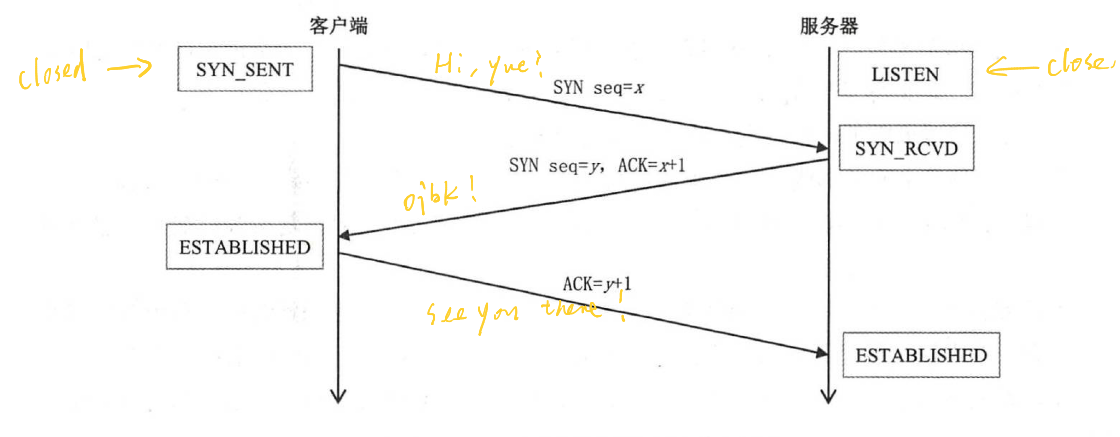
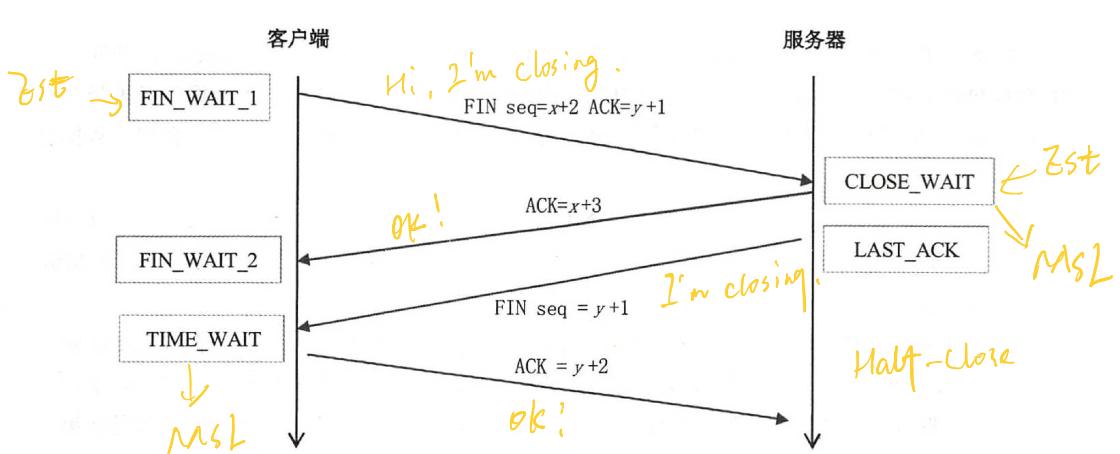
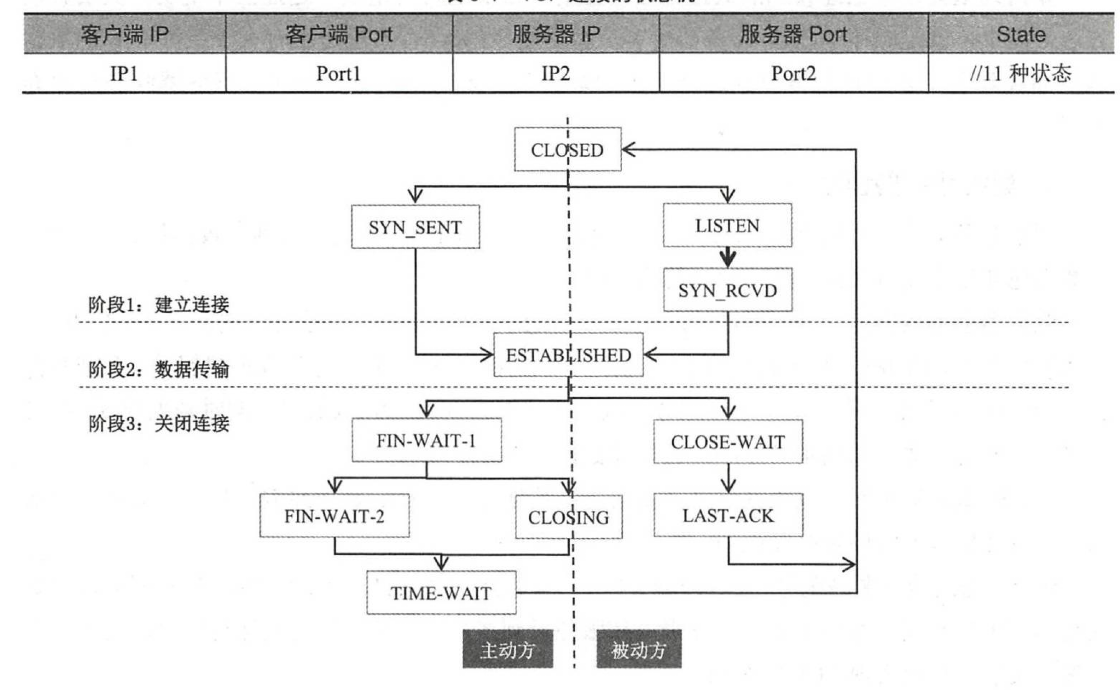

## QUIC(Quick UDP Internet Connection)
这是由Google基于UDP协议实现的多路复用传输协议。

![quic.png](assets/quic.png)

### 不丢包(Raid5和Raid6)
tcp是使用重传机制来实现的不丢包，那是否还有其他的方法可以实现不丢包呢？当然有，做过存储的人一定非常熟悉Raid5和Raid6算法。

![raid5.png](assets/raid5.png)

![raid6.png](assets/raid6.png)

### 更少的RTT(Round-Trip Time)
如上面介绍的，建立一个HTTPS的连接，需要其次握手，TCP三次握手，TSL四次握手。而QUIC可以做到最小握手0次。

![quic-connect.gif](assets/quic-connect.gif)

![quic-lifetime.jpeg](assets/quic-lifetime.jpeg)

- 客户端判断本地是否已有服务器的全部配置参数，如果有则直接跳转到(5)，否则继续
- 客户端向服务器发送inchoate client hello(CHLO)消息，请求服务器传输配置参数
- 服务器收到CHLO，回复rejection(REJ)消息，其中包含服务器的部分配置参数
- 客户端收到REJ，提取并存储服务器配置参数，跳回到(1)
- 客户端向服务器发送full client hello消息，开始正式握手，消息中包括客户端选择的公开数。此时客户端根据获取的服务器配置参数和自己选择的公开数，可以计算出初始密钥。
- 服务器收到full client hello，如果不同意连接就回复REJ，同(3)；如果同意连接，根据客户端的公开数计算出初始密钥，回复server hello(SHLO)消息，SHLO用初始密钥加密，并且其中包含服务器选择的一个临时公开数。
- 客户端收到服务器的回复，如果是REJ则情况同(4)；如果是SHLO，则尝试用初始密钥解密，提取出临时公开数
- 客户端和服务器根据临时公开数和初始密钥，各自基于SHA-256算法推导出会话密钥
- 双方更换为使用会话密钥通信，初始密钥此时已无用，QUIC握手过程完毕。之后会话密钥更新的流程与以上过程类似，只是数据包中的某些字段略有不同。

### 连接迁移
TCP的连接使用4元组(客户端ip,客户端port,服务端ip,服务端port)来确实唯一的逻辑连接，这在PC端上没有问题，但是在移动端使用WIFI或者4G，客户端IP会发生变化，意味着需要频繁的建立和关闭连接。那这种4元组的逻辑表示就会出问题了。QUIC协议会使用在客户端生成的一个64位数字标识连接，虽然客户端的IP和Port发生漂移，但是64位数字不变，则这条逻辑连接一直会存在。
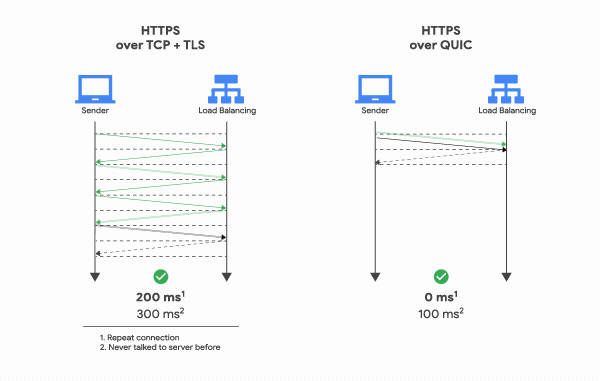
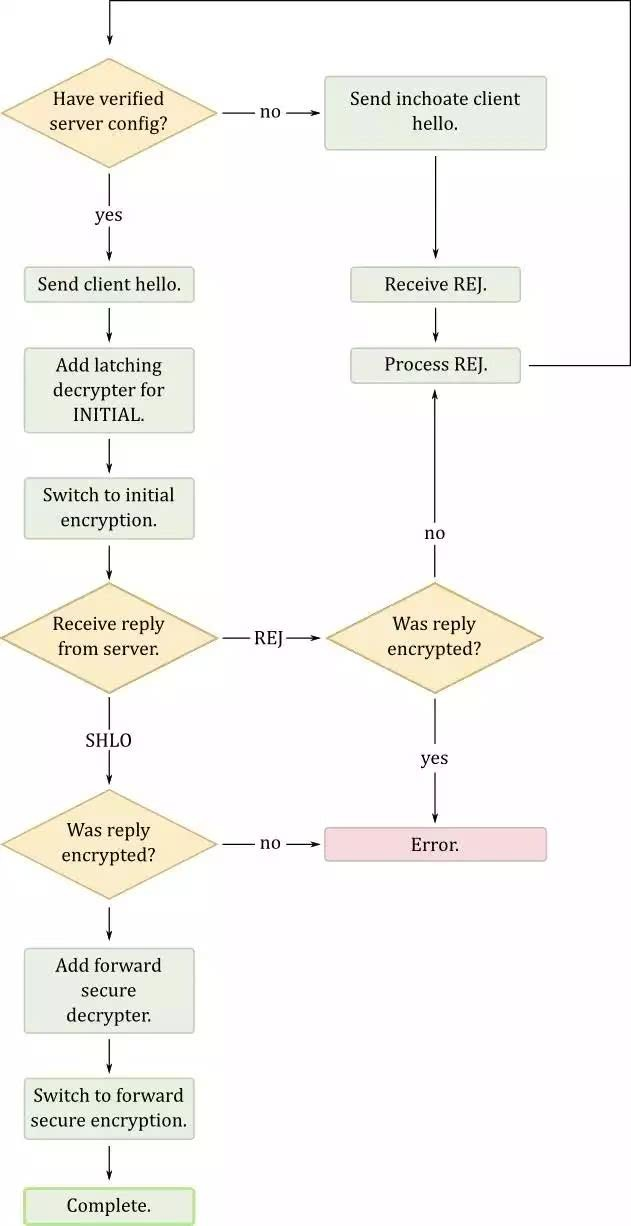
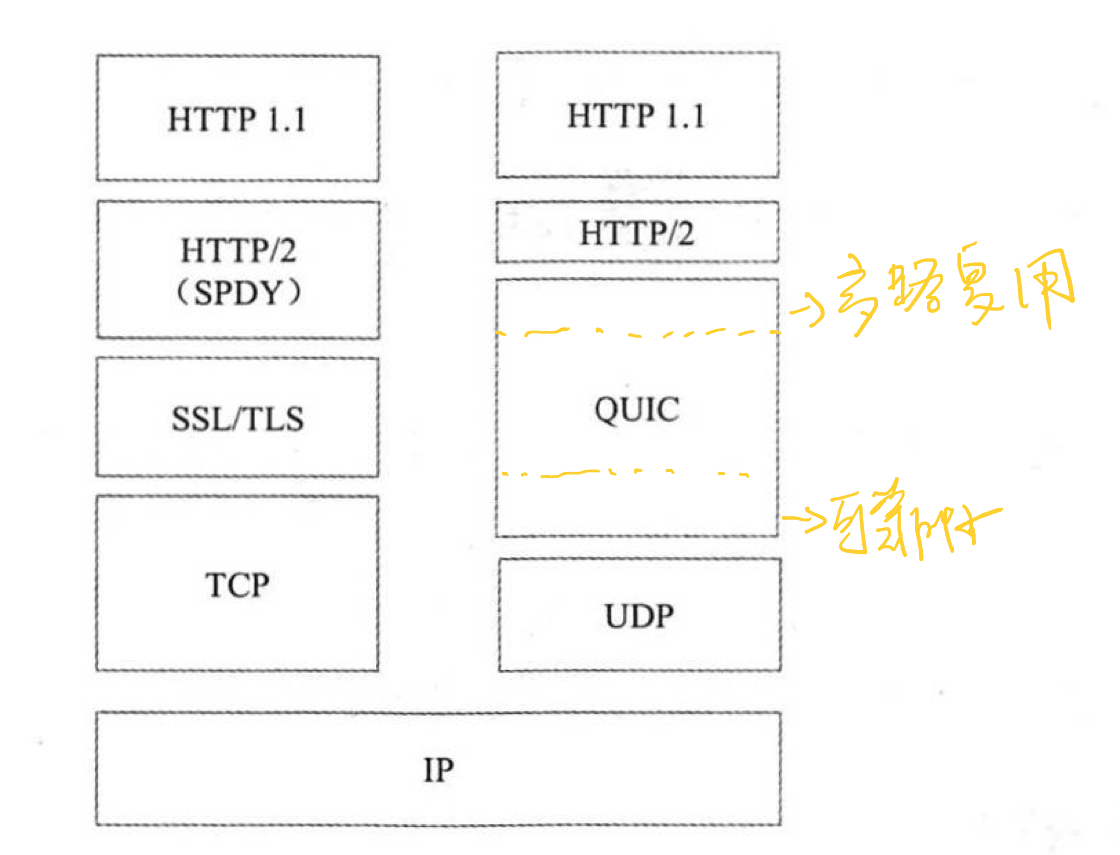
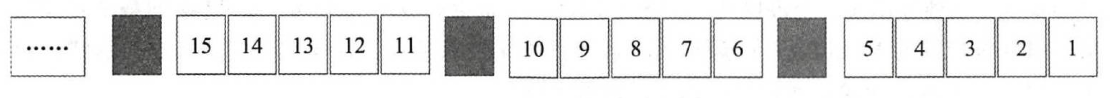
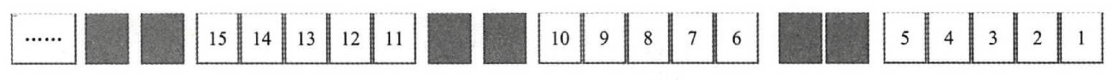